# Cascade - Tying Everything Together

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight


from source import run_single_experiment, display_top_f1_scores, return_class, run_algorithm_analysis

pd.options.display.max_rows = 999
plt.style.use('fivethirtyeight')

# Task: Using low popularity classifier separate songs and apply a different classifier to rank the rest

This is a notebook for the [blog post](http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-3.html). The main idea is to investigate Machine Learning Design Patterns described in [this](https://www.oreilly.com/library/view/machine-learning-design/9781098115777/) book. 
This notebook is investigation of **Cascade** design pattern - combination of two ML models to perform a task of track popularity prediction.

Previous blog post on track popularity prediciton is [here](http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-1.html) and on very low popularity songs separation - [here](http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-2.html)
                                                       

Data was downloaded from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and you can find a description of this dataset there.

## Load data

In [2]:
data = pd.read_csv("./spotify_track_features_data.csv")

In [3]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [4]:
data_last_decade = data[data["year"] >= 2011]
print(f"Total tracks from the last decadelen: {len(data_last_decade)}")

Total tracks from the last decadelen: 19788


Split our dataset to train/test data before moving forward

In [5]:
AUDIO_FEATURES = [
    "valence",
    "acousticness",
    "danceability",
    "energy",
    "explicit",
    "instrumentalness",
    "key",
    "liveness",
    "mode",
    "speechiness",
    "tempo",
]
TARGET = "popularity"

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_last_decade[AUDIO_FEATURES], data_last_decade[TARGET], test_size=0.2, random_state=42)

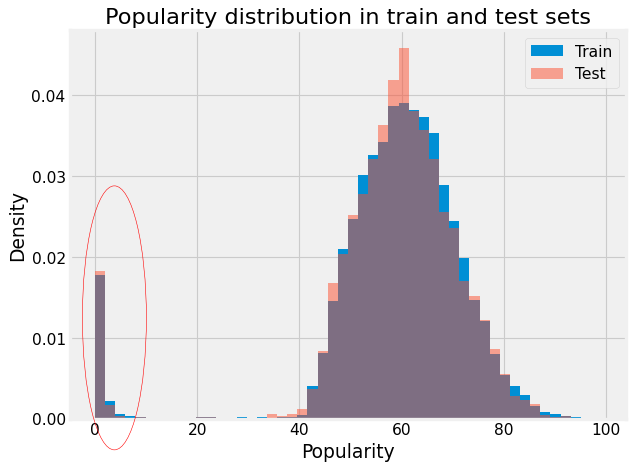

In [7]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_, bins, _ = plt.hist(y_train.to_list(), bins=50, density=True, label="Train")
_ = plt.hist(y_test.to_list(), bins=bins, alpha=0.5, density=True, label="Test")
e = Ellipse(xy=(0.15,0.28), width=0.1, height=0.55)
e.set_edgecolor("red")
e.set_facecolor("none")
e.set_alpha(1)
fig.add_artist(e)
_ = plt.title("Popularity distribution in train and test sets")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

Looking at the graph above, the main idea is to separate circled tracks - low popularity tracks - first, with a use of trained classifier. Then, we can train a model to predict popularity of the songs without the outliers (low popularity songs).

## Cascade interface

In [ ]:
@dataclass
class TaskDefinition:
    
    algorithm: BaseModel
    label_prep: Callable
        

@dataclass
class DataSample:
    
    train_features: pd.DataFrame
    train_labels: pd.DataFrame
    test_features: pd.DataFrame
    test_labels: pd.DataFrame


class PopularityPredictionCascade:
    
    def __init__(self, first_task: TaskDefinition, second_task: TaskDefinition) -> None:
        self.task_1 = first_task
        self.task_2 = second_task
        
    def train(self, training_data: DataSample) -> None:
        task_1_labels = self.task_1.label_prep(training_data.train_labels)
        task_1_algo = self.task_1.agorithm.fit(training_data.training_features, task_1_labels)
        
        
        

## `Low popularity` classifier

In the previous [post](http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-2.html), we build several classifiers to predict low popularity and found that the best one based on `f1 score` was classifier with weighted training examples - minority class was weighted 7 times more than the majority class. Main metrics: `precision`: 0.524, `recall`: 0.457 and `f1 score`: 0.489 at the best f1 score `threshold` of 0.545.


Let us train this classifier again and "clean" our training data for the song popularity prediction.

In [8]:
# Preparing alternative targets for classification
y_train_low_pop = (y_train <= 20).astype(float)
y_test_low_pop = (y_test <= 20).astype(float)

print(f"Frequency of low popularity songs in train set: {y_train_low_pop.mean():.4f}")
print(f"Frequency of low popularity songs in test set: {y_test_low_pop.mean():.4f}")

Frequency of low popularity songs in train set: 0.0424
Frequency of low popularity songs in test set: 0.0414


In [9]:
adjusted_weights = compute_sample_weight({0: 1, 1: 7}, y_train_low_pop)
low_pop_predictor = GradientBoostingClassifier().fit(X_train, y_train_low_pop, adjusted_weights)
preds = low_pop_predictor.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test_low_pop, preds)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    f1score = 2 * (precision * recall) / (precision + recall)
    
display_top_f1_scores(precision, recall, f1score, thresholds)

,Precision,Recall,F1-score,Threshold
3460,0.524476,0.457317,0.488599,0.545446
3459,0.520833,0.457317,0.487013,0.533943
3458,0.517241,0.457317,0.485437,0.533571
3457,0.513699,0.457317,0.483871,0.532221
3461,0.521127,0.451220,0.483660,0.556385


We can now "clean" the training dataset with the build model

In [10]:
train_set_predictions = low_pop_predictor.predict_proba(X_train)[:, 1]

In [11]:
X_train_cleaned = X_train[train_set_predictions <= 0.545446]
y_train_cleaned = y_train[train_set_predictions <= 0.545446]
y_train_removed = y_train[train_set_predictions > 0.545446]

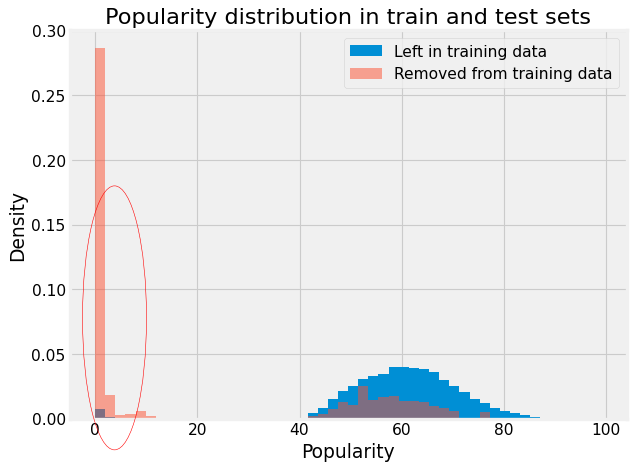

In [12]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.hist(y_train_cleaned.to_list(), bins=bins, density=True, label="Left in training data")
_ = plt.hist(y_train_removed.to_list(), bins=bins, alpha=0.5, density=True, label="Removed from training data")
e = Ellipse(xy=(0.15,0.28), width=0.1, height=0.55)
e.set_edgecolor("red")
e.set_facecolor("none")
e.set_alpha(1)
fig.add_artist(e)
_ = plt.title("Popularity distribution in train and test sets")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

In [13]:
## Do a split graph, where one shows 0-20 scores and the other shows the rest 20-100.


## Traing song popularity predictor on "cleaned" dataset

Sicne the best modeling approach from [the first part of this series](http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-1.html) was with `neutral class` approach, we will use the same here to build the model.

In [14]:
y_train_neutral_class = y_train_cleaned.apply(lambda v: return_class(v, y_train_cleaned.quantile(0.4), y_train_cleaned.quantile(0.6)))


In [ ]:
_, _ = run_algorithm_analysis("Classification with Neutral Class", GradientBoostingClassifier, X_train, y_train_neutral_class, X_test, y_test)


## Evaluating the cascade on test set

## Different goals for cleaning task?

## Discussion


....